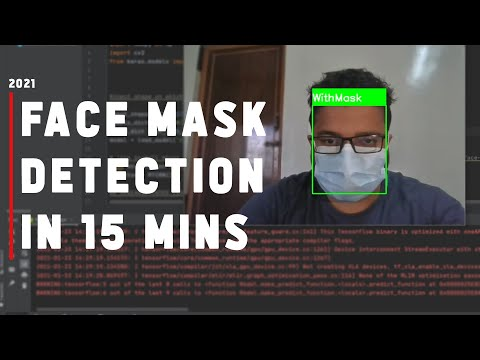

In [10]:
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo('o2vPYufwQNU',width=700, height=400)

In [1]:
#importing required libraries

import numpy as np
import pandas as pd

import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense,BatchNormalization,Dropout,Activation,Flatten
from keras.layers import Lambda, Input, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator,load_img


from tqdm.autonotebook import tqdm

import warnings
warnings.filterwarnings('ignore')

C:\Users\coder\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
print('GPU available!!!' if tf.config.list_physical_devices('GPU') else 'GPU is not available :(')

GPU available!!!


In [3]:
#checking version
print(f'TF verion: {tf.__version__}')
print(f'Keras version: {tf.keras.__version__}')

TF verion: 2.3.1
Keras version: 2.4.0


In [4]:
#setting up seed
seed = 50
def seed_everything(seed):
    os.environ['PYTHONSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed)
    

### Data is available at: https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

NOTE: I have created a folder 'Test' and put a mixure of with mask and without mask images. In original dataset these images are placed under separate folders.

In [5]:
#directories for data 
train_dir = 'Face_Mask_Dataset/Train' #put the directory for train data
test_dir = 'Face_Mask_Dataset' #put the directory for test data
val_dir = 'Face_Mask_Dataset/Validation'##put the directory for validation data

(42, 42, 3)


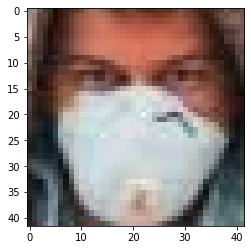

In [6]:
img= load_img('Face_Mask_Dataset/Train/WithMask/4.png')
plt.imshow(img)
print(np.array(img).shape)

(100, 100, 3)


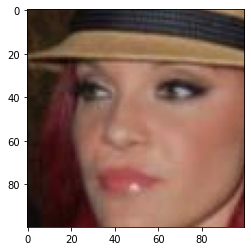

In [7]:
img= load_img('Face_Mask_Dataset/Train/WithoutMask/4.png')
plt.imshow(img)
print(np.array(img).shape)

## Hyperparameters:

In [8]:
input_shape = (120,120,3)
batch_size = 32
epochs = 20
learn_rate = 0.001
adam = Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)


### Data augmentation:

#### 1. Data augmentation encompasses a wide range of techniques used to generate “new” training samples from the original ones by applying random jitters and perturbations (but at the same time ensuring that the class labels of the data are not changed).
#### 2.The basic idea behind the augmentation is to train the model on all kind of possible transformations of an image
#### 3. Here we are using flow_from_directory. This is because we have limited ram and we need to get images in batches

In [9]:
#Data Generator


datagen = ImageDataGenerator(
                    rotation_range = 30,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    brightness_range = [0.5,1.5],
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

# as we don not need all transformation during validation and test

datagen_val = ImageDataGenerator()
datagen_test = ImageDataGenerator()

In [10]:
train_generator= datagen.flow_from_directory(directory=train_dir,
                                            class_mode="sparse", target_size=(input_shape[0],input_shape[0]), batch_size=batch_size,shuffle = True,
                                             seed = seed,interpolation = "nearest")

Found 10000 images belonging to 2 classes.


In [11]:
val_generator=datagen_val.flow_from_directory(directory=val_dir,
                                            class_mode="sparse", target_size=(input_shape[0],input_shape[0]), batch_size=batch_size,shuffle = True,
                                             seed = seed,interpolation = "nearest")

Found 800 images belonging to 2 classes.


In [12]:
#test datagen

test_generator = datagen_test.flow_from_directory(test_dir,
                                               batch_size = 1, # as we want all images in one batch during prediction (we can take any batch size)
                                               target_size =(input_shape[0],input_shape[0]),
                                                classes=['Test'], # https://kylewbanks.com/blog/loading-unlabeled-images-with-imagedatagenerator-flowfromdirectory-keras
                                               color_mode ='rgb',
                                              seed = seed
                                               ) 

Found 939 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


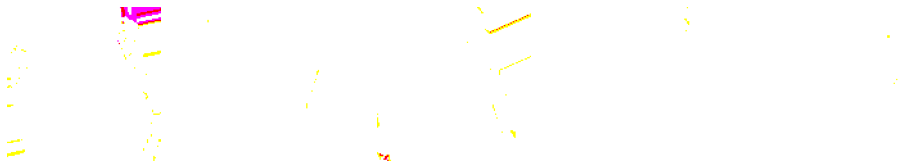

In [13]:
#plotting some images from image generator https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/

fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(16,16))


for i in range (5):
    
    image = next(train_generator)[0][0] # getting images
    
    image = np.squeeze(image) # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    
    ax[i].imshow(image)
    ax[i].axis('off')

## Callbacks:

In [14]:
# Stop training when the validation loss metric has stopped decreasing for 5 epochs.
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               mode = 'min',
                               restore_best_weights = True)

# Save the model with the minimum validation loss
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = 'val_loss',
                             verbose = 1,
                             mode = 'min', 
                             save_best_only = True)
# reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              min_lr = 0.001,
                              mode = 'min',
                              verbose = 1)

## Building Model:

In [15]:
from tensorflow.keras.applications import EfficientNetB3
effB3 = EfficientNetB3(input_shape = input_shape, include_top = False, weights = 'imagenet')

In [16]:
#mapping encoded values to class labels
labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
n_classes = len(labels)
print(labels) # now we have encoded values as keys and class name as valaues. This helps during decoding the predicition
print(f'There are total {n_classes} number of classes present')

{0: 'WithMask', 1: 'WithoutMask'}
There are total 2 number of classes present


In [17]:
#creating a function to build the FC by taking the base model and return the final model

def build_model(base_modelx):
    
#     for layer in base_modelx.layers:
#         layer.trainable = False
    
    model = Sequential(base_modelx)
#     model.add(Flatten())
    model.add(GlobalAveragePooling2D())
#     model.add(Dropout(0.3))
    model.add(Dense(256,activation ='relu'))#, kernel_regularizer = tf.keras.regularizers.l2(0.01)))

    model.add(Dense(n_classes,activation='softmax'))
    
    print(model.summary())
    
    model.compile(loss = 'sparse_categorical_crossentropy',optimizer = adam,metrics =['accuracy'])
    
    return model

In [18]:
#build the model

model = build_model(effB3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 4, 4, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 11,177,521
Trainable params: 11,090,218
Non-trainable params: 87,303
_________________________________________________________________
None


In [19]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

## Model Training:

In [20]:
model.fit(train_generator,
                    validation_data = val_generator,
                    epochs = epochs,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early_stopping, checkpoint, reduce_lr]
                   )

Epoch 1/20
312/312 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9714
Epoch 00001: val_loss improved from inf to 0.01604, saving model to best_model.hdf5
312/312 [==============================] - 73s 234ms/step - loss: 0.0823 - accuracy: 0.9714 - val_loss: 0.0160 - val_accuracy: 0.9962
Epoch 2/20
312/312 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9874 ETA: 2s
Epoch 00002: val_loss improved from 0.01604 to 0.01002, saving model to best_model.hdf5
312/312 [==============================] - 56s 180ms/step - loss: 0.0390 - accuracy: 0.9874 - val_loss: 0.0100 - val_accuracy: 0.9975
Epoch 3/20
312/312 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9920
Epoch 00003: val_loss improved from 0.01002 to 0.00552, saving model to best_model.hdf5
312/312 [==============================] - 56s 180ms/step - loss: 0.0259 - accuracy: 0.9920 - val_loss: 0.0055 - val_accuracy: 0.9975
Epoch 4/20
312/312 [======================

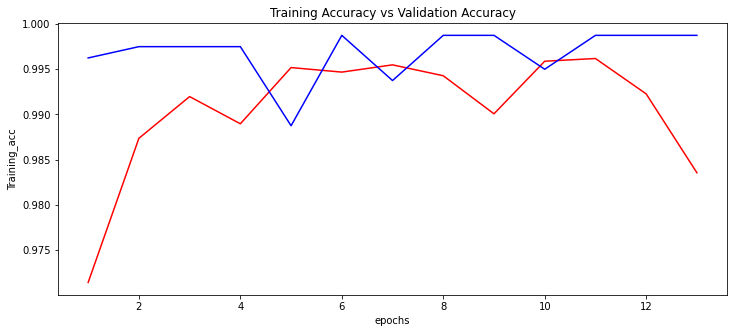

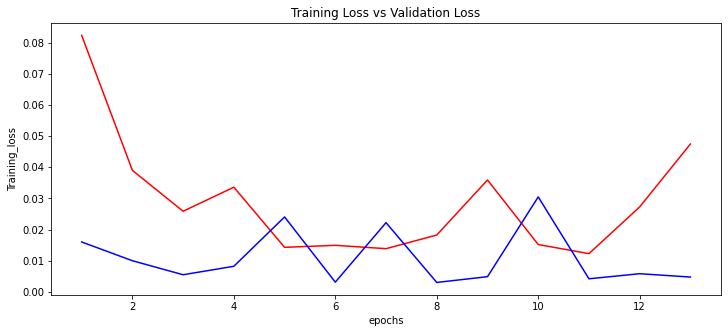

In [21]:
#Ploting acc and loss

def plot_result(modelx):
    results = pd.DataFrame({'epochs':list(range(1,len(modelx.history.history['accuracy'])+1)),'Training_acc':modelx.history.history['accuracy'],'Validation_acc':modelx.history.history['val_accuracy'],
                          'Training_loss':modelx.history.history['loss'],'Validation_loss':modelx.history.history['val_loss']})

    plt.figure(figsize=(12,5))
    sns.lineplot(x = 'epochs', y ='Training_acc', data = results, color='r' )
    sns.lineplot(x = 'epochs', y ='Validation_acc', data = results, color='blue' )
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(x = 'epochs', y ='Training_loss', data = results, color='r' )
    sns.lineplot(x = 'epochs', y ='Validation_loss', data = results, color='blue' )
    plt.title('Training Loss vs Validation Loss')
    plt.show()

plot_result(model)

In [22]:
#predicting

pred = model.predict(test_generator)
pred

array([[7.3751560e-12, 1.0000000e+00],
       [9.9998212e-01, 1.7837516e-05],
       [9.9999666e-01, 3.3027293e-06],
       ...,
       [9.9953020e-01, 4.6987864e-04],
       [9.9996233e-01, 3.7644200e-05],
       [9.9974436e-01, 2.5562081e-04]], dtype=float32)

In [23]:
# First prediction
n=1
print(pred[n])
print(f"Max value (probability of prediction): {np.max(pred[n])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(pred[n])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(pred[n])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {labels[(np.argmax(pred[n]))]}")

[9.9998212e-01 1.7837516e-05]
Max value (probability of prediction): 0.9999821186065674
Sum: 0.9999999403953552
Max index: 0
Predicted label: WithMask


# Now please check the file: face_detector.py